# Eng to French Translation using Deep Learning and Transformers

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import Model, Sequential
from keras.layers import Input,LSTM, Dense, Embedding, Attention
from keras.layers import TimeDistributed, RepeatVector,Bidirectional
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical, plot_model
from sklearn.model_selection import train_test_split
import re
import string
from unicodedata import normalize

**Load Dataset**

In [3]:
def load_dataset(filepath):
    df = pd.read_csv(filepath,encoding='utf-8')
    print("Number of records:",len(df))
    return df

In [4]:
df = load_dataset(r'/kaggle/input/language-translation-englishfrench/eng_-french.csv')
df.head()

Number of records: 175621


,English words/sentences,French words/sentences
0,Hi.,Salut!
1,Run!,Cours !
2,Run!,Courez !
3,Who?,Qui ?
4,Wow!,Ça alors !


# Method 1: Deep Learning

**Data Pre-processing**

In [5]:
def preprocess_text(text):
    # normalize unicode characters
    text = normalize('NFD',text).encode("ascii","ignore")
    text = text.decode("UTF-8")
    # convert to string
    text = str(text)
    # convert to lowercase
    text = text.lower()
    # remove punctuation
    text = text.translate(str.maketrans('','',string.punctuation))
    # remove non-printable chars from text
    re_print = re.compile('[^%s]'% re.escape(string.printable))
    text = re_print.sub('',text)
    # remove numbers
    text = re.sub(r'[\d]+','',text)
    # remove multiple spaces
    text = ' '.join(text.split())
    return text

In [6]:
df_copy = df.copy()
df_copy['English words/sentences'] = df_copy.loc[:,'English words/sentences'].apply(
    lambda x:preprocess_text(x))
df_copy['French words/sentences'] = df_copy.loc[:,'French words/sentences'].apply(
    lambda x:preprocess_text(x))
df_copy.head()

,English words/sentences,French words/sentences
0,hi,salut
1,run,cours
2,run,courez
3,who,qui
4,wow,ca alors


**Tokenizing data**

In [8]:
def tokenize(text):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(text)
    return tokenizer

In [9]:
# English tokenizer

eng_tokenizer = tokenize(df_copy['English words/sentences'])
eng_vocab_size = len(eng_tokenizer.word_index) + 1

# French tokenizer
fr_tokenizer = tokenize(df_copy['French words/sentences'])
fr_vocab_size = len(fr_tokenizer.word_index) + 1

# Sequences
seq_eng = eng_tokenizer.texts_to_sequences(df_copy['English words/sentences'])
seq_fr = fr_tokenizer.texts_to_sequences(df_copy['French words/sentences'])

# Padding
max_length = max([len(seq) for seq in seq_eng + seq_fr])
seq_eng_final = pad_sequences(seq_eng,maxlen=max_length,padding="post")
seq_fr_final = pad_sequences(seq_fr,maxlen=max_length,padding="post")

print("English Vocab Size:",eng_vocab_size)
print("French Vocab Size:",fr_vocab_size)
print("Maximum length of sequences:",max_length)

English Vocab Size: 14407
French Vocab Size: 28133
Maximum length of sequences: 55


**Train/Test Split**

In [10]:
X_train,X_test,y_train,y_test = train_test_split(seq_eng_final,
                                                 seq_fr_final,
                                                 test_size=0.2,
                                                 shuffle=True,
                                                 random_state=42)
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((140496, 55), (35125, 55), (140496, 55), (35125, 55))

**Model Building - Functional**

In [13]:
vector_length = 100

# Encoder
enc_inputs = Input(shape=(max_length,))
enc_embedding = Embedding(input_dim=eng_vocab_size,output_dim=vector_length)(enc_inputs)
enc_LSTM = LSTM(256,return_state=True)
enc_output,h,c = enc_LSTM(enc_embedding)
enc_states = [h,c]

# Decoder
dec_inputs = Input(shape=(max_length,))
dec_embedding = Embedding(input_dim=fr_vocab_size,output_dim=vector_length)(dec_inputs)
dec_LSTM = LSTM(256,return_sequences=True,return_state=True)
dec_output,_,_ = dec_LSTM(dec_embedding,initial_state=enc_states)


dec_dense = Dense(fr_vocab_size,activation="softmax")
output = dec_dense(dec_output)

# Model
model = Model([enc_inputs,dec_inputs],output)

# Compile Model
model.compile(optimizer='adam',loss="sparse_categorical_crossentropy",metrics=["accuracy"])

In [14]:
# Model training

model.fit([X_train,X_train],y_train,epochs=2,validation_data=([X_test,X_test],y_test))

Epoch 1/2
4391/4391 [==============================] - 387s 87ms/step - loss: 0.7429 - accuracy: 0.8988 - val_loss: 0.6046 - val_accuracy: 0.9075
Epoch 2/2
4391/4391 [==============================] - 391s 89ms/step - loss: 0.5400 - accuracy: 0.9119 - val_loss: 0.5164 - val_accuracy: 0.9141


**Model Building - Sequential**

In [14]:
vector_length = 100
model = Sequential()
model.add(Embedding(input_dim=eng_vocab_size,output_dim=vector_length,input_length=max_length,mask_zero=True))
model.add(Bidirectional(LSTM(256)))
model.add(RepeatVector(max_length))
model.add(LSTM(256,return_sequences=True))
model.add(TimeDistributed(Dense(fr_vocab_size,activation="softmax")))
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 55, 100)           1440700   
                                                                 
 bidirectional (Bidirectiona  (None, 512)              731136    
 l)                                                              
                                                                 
 repeat_vector (RepeatVector  (None, 55, 512)          0         
 )                                                               
                                                                 
 lstm_1 (LSTM)               (None, 55, 256)           787456    
                                                                 
 time_distributed (TimeDistr  (None, 55, 28133)        7230181   
 ibuted)                                                         
                                                      

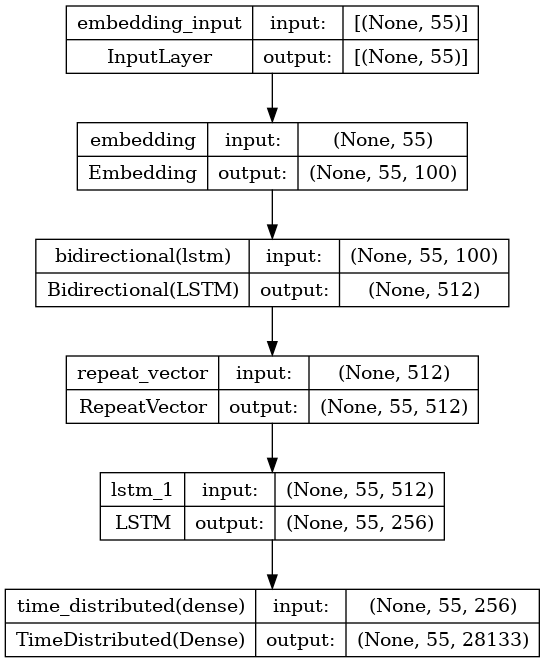

In [16]:
plot_model(model,to_file="model.png",show_shapes=True)

In [18]:
model.compile(optimizer="adam",loss="sparse_categorical_crossentropy",metrics=['accuracy'])
model.fit(X_train,y_train,epochs=5,validation_data=(X_test,y_test))

Epoch 1/5
4391/4391 [==============================] - 517s 115ms/step - loss: 0.7322 - accuracy: 0.8962 - val_loss: 0.6355 - val_accuracy: 0.9047
Epoch 2/5
4391/4391 [==============================] - 493s 112ms/step - loss: 0.5589 - accuracy: 0.9099 - val_loss: 0.5177 - val_accuracy: 0.9136
Epoch 3/5
4391/4391 [==============================] - 515s 117ms/step - loss: 0.4518 - accuracy: 0.9177 - val_loss: 0.4553 - val_accuracy: 0.9188
Epoch 4/5
4391/4391 [==============================] - 514s 117ms/step - loss: 0.3816 - accuracy: 0.9236 - val_loss: 0.4193 - val_accuracy: 0.9223
Epoch 5/5
4391/4391 [==============================] - 513s 117ms/step - loss: 0.3334 - accuracy: 0.9284 - val_loss: 0.3997 - val_accuracy: 0.9246


**Predictions**

In [28]:
def translation(input_sentence):
    input_sentence = preprocess_text(str(input_sentence))
    input_seq = eng_tokenizer.texts_to_sequences([input_sentence])
    input_seq_final = pad_sequences(input_seq,maxlen=max_length,padding="post")
    prediction = model.predict([input_seq_final])
    output_translation = np.argmax(prediction,axis=-1)
    
    output_sentence = []
    for i in output_translation[0]:
        if i in fr_tokenizer.index_word:
            output_sentence.append(fr_tokenizer.index_word[i])
        else:
            output_sentence.append(' ')
    return ' '.join(output_sentence)

input_sentence = "How are you?"
translated = translation(input_sentence)
print(f"Input: {input_sentence}")
print(f"Translated: {translated}")

1/1 [==============================] - 0s 23ms/step
Input: How are you?
Translated: comment vous                                                                                                          


In [29]:
input_sentence = "Where are you going?"
translated = translation(input_sentence)
print(f"Input: {input_sentence}")
print(f"Translated: {translated}")

1/1 [==============================] - 0s 24ms/step
Input: Where are you going?
Translated: ou allezvous                                                                                                          


# Method 2: Transformers (Pre-trained Pipeline)

In [7]:
from transformers import pipeline
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from nltk.tokenize import RegexpTokenizer

In [34]:
# Create a dictionary of eng-french tokens showing multiple french words for unique english word

eng2fr = {}
for eng,fr in df_copy.itertuples(index=False):
    if eng not in eng2fr:
        eng2fr[eng] = []
    eng2fr[eng].append(fr)

In [35]:
dict(list(eng2fr.items())[0:10]) # view first 10 items

{'hi': ['salut'],
 'run': ['cours', 'courez'],
 'who': ['qui'],
 'wow': ['ca alors'],
 'fire': ['au feu'],
 'help': ['a laide'],
 'jump': ['saute'],
 'stop': ['ca suffit', 'stop', 'arretetoi'],
 'wait': ['attends', 'attendez'],
 'go on': ['poursuis', 'continuez', 'poursuivez']}

In [36]:
# The documents have to be a list of lists where each french token is a list in itself
# This is essential for B Score calculation

eng2fr_tokens = {}
tokenizer = RegexpTokenizer(r'\w+')
for eng,fr_list in eng2fr.items():
    fr_tokens = []
    for text in fr_list:
        tokens = tokenizer.tokenize(text.lower())
        fr_tokens.append([text])
    eng2fr_tokens[eng] = fr_tokens

In [37]:
dict(list(eng2fr_tokens.items())[0:10]) # view first 10 items

{'hi': [['salut']],
 'run': [['cours'], ['courez']],
 'who': [['qui']],
 'wow': [['ca alors']],
 'fire': [['au feu']],
 'help': [['a laide']],
 'jump': [['saute']],
 'stop': [['ca suffit'], ['stop'], ['arretetoi']],
 'wait': [['attends'], ['attendez']],
 'go on': [['poursuis'], ['continuez'], ['poursuivez']]}

In [12]:
!pip install sacremoses

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 880.6/880.6 kB 13.8 MB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
  Created wheel for sacremoses: filename=sacremoses-0.0.53-py3-none-any.whl size=895260 sha256=333cd8d84b9410214f9ae742f6caa684a699f334b579e3dd87969bb27adc38fe
  Stored in directory: /root/.cache/pip/wheels/00/24/97/a2ea5324f36bc626e1ea0267f33db6aa80d157ee977e9e42fb
Successfully built sacremoses


In [13]:
translator = pipeline('translation',model='Helsinki-NLP/opus-mt-en-fr',device=0)

In [14]:
translator('I like eggs and chocolate')

[{'translation_text': "J'aime les œufs et le chocolat"}]

In [15]:
eng_phrases = list(eng2fr.keys())
len(eng_phrases)

122942

In [17]:
eng_phrases_subset = eng_phrases[20000:21000]
translations = translator(eng_phrases_subset)

In [21]:
print("Original english sentence: ",eng_phrases_subset[0])
print("Original french sentence: ",list(eng2fr.values())[20000:21000][0])
print("Translated sentence: ",translations[0]['translation_text'])

Original english sentence:  tom eats like a pig
Original french sentence:  ['tom mange comme un cochon', 'thomas mange comme un cochon']
Translated sentence:  Tom mange comme un porc


In [46]:
print("Original english sentence: ",eng_phrases_subset[4])
print("Original french sentence: ",eng2fr_tokens[eng_phrases_subset[4]])
print("Translated sentence: ",translations[4]['translation_text'])

Original english sentence:  tom forced me to go
Original french sentence:  [['tom ma force a y aller']]
Translated sentence:  Tom m'a forcé à partir.


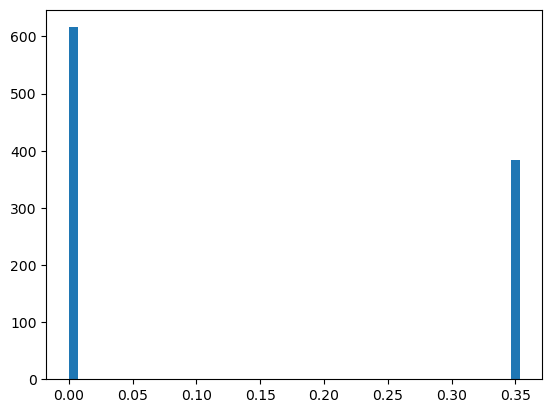

In [73]:
# Evaluation

smoother = SmoothingFunction()

scores = []
for eng,pred in zip(eng_phrases_subset,translations):
    matches = eng2fr_tokens[eng]
    fr_pred = []
    
    # process translations
    trans_pred = preprocess_text(pred['translation_text'])
    fr_pred.append(trans_pred)
    score = sentence_bleu(matches,fr_pred,smoothing_function=smoother.method3)
    scores.append(score)
    
plt.hist(scores,bins=50)
plt.show()

In [74]:
np.mean(scores)

0.13576450198781714

In [75]:
np.random.seed(1)

def print_random_translation():
    i = np.random.choice(len(eng_phrases_subset))
    eng = eng_phrases_subset[i]
    print('EN:',eng)

    translation = translations[i]['translation_text']
    print('FR Translation:',translation)

    matches = eng2fr[eng]
    print('Matches:',matches)

In [76]:
print_random_translation()

EN: tom is a daydreamer
FR Translation: Tom est un rêveur
Matches: ['tom est un reveur']


In [77]:
print_random_translation()

EN: was it all worth it
FR Translation: était-ce que ça en valait la peine ?
Matches: ['estce que ca en valait la peine']


# Method 3: Transformers (Fine Tuning)

In [7]:
!pip install evaluate sacrebleu

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 kB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.9/118.9 kB 11.5 MB/s eta 0:00:00


In [8]:
from huggingface_hub import notebook_login
notebook_login()

In [9]:
# Convert dataframe to datasets format

from datasets import load_dataset
df_copy.to_csv("df.csv",index=None) # save dataframe

raw_datasets = load_dataset("csv",data_files="df.csv")
raw_datasets

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/datasets/packaged_modules/csv/csv.py:154: FutureWarning: the 'mangle_dupe_cols' keyword is deprecated and will be removed in a future version. Please take steps to stop the use of 'mangle_dupe_cols'
  csv_file_reader = pd.read_csv(file, iterator=True, dtype=dtype, **self.config.read_csv_kwargs)


Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/default-52d8ed8d647da4ea/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['English words/sentences', 'French words/sentences'],
        num_rows: 175621
    })
})

In [10]:
# Split raw dataset into train and test

split = raw_datasets['train'].train_test_split(train_size=0.8,seed=42)
split

DatasetDict({
    train: Dataset({
        features: ['English words/sentences', 'French words/sentences'],
        num_rows: 140496
    })
    test: Dataset({
        features: ['English words/sentences', 'French words/sentences'],
        num_rows: 35125
    })
})

In [11]:
# Define tokenizer

from transformers import AutoTokenizer

checkpoint = "t5-small"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

In [12]:
# Tokenizing function

prefix = "translate English to French: "

def preprocess_function(batch):
    inputs = [prefix + doc for doc in batch["English words/sentences"]]
    targets = [doc for doc in batch["French words/sentences"]]
    model_inputs = tokenizer(inputs, text_target=targets, max_length=128, truncation=True)
    return model_inputs

In [13]:
tokenized_dataset = split.map(preprocess_function, batched=True)
tokenized_dataset

  0%|          | 0/141 [00:00<?, ?ba/s]

  0%|          | 0/36 [00:00<?, ?ba/s]

DatasetDict({
    train: Dataset({
        features: ['English words/sentences', 'French words/sentences', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 140496
    })
    test: Dataset({
        features: ['English words/sentences', 'French words/sentences', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 35125
    })
})

In [14]:
# Dynamic Padding

from transformers import DataCollatorForSeq2Seq

data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer, model=checkpoint)

In [15]:
# Evaluate

import evaluate
metric = evaluate.load("sacrebleu")


def postprocess_text(preds, labels):
    preds = [pred.strip() for pred in preds]
    labels = [[label.strip()] for label in labels]

    return preds, labels


def compute_metrics(eval_preds):
    preds, labels = eval_preds
    if isinstance(preds, tuple):
        preds = preds[0]
    decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)
    decoded_preds, decoded_labels = postprocess_text(decoded_preds, decoded_labels)

    result = metric.compute(predictions=decoded_preds, references=decoded_labels)
    result = {"bleu": result["score"]}

    prediction_lens = [np.count_nonzero(pred != tokenizer.pad_token_id) for pred in preds]
    result["gen_len"] = np.mean(prediction_lens)
    result = {k: round(v, 4) for k, v in result.items()}
    return result

In [16]:
# Train

from transformers import AutoModelForSeq2SeqLM, Seq2SeqTrainingArguments, Seq2SeqTrainer

model = AutoModelForSeq2SeqLM.from_pretrained(checkpoint)

In [17]:
training_args = Seq2SeqTrainingArguments(
    output_dir="en_fr_translation",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=5,
    weight_decay=0.01,
    save_total_limit=3,
    num_train_epochs=2,
    predict_with_generate=True,
    fp16=True,
    push_to_hub=False,
)

trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["test"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

trainer.train()

/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Epoch,Training Loss,Validation Loss,Bleu,Gen Len
1,1.389100,1.129929,33.211600,11.800500
2,1.306500,1.069860,34.626300,11.793100


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead u

TrainOutput(global_step=8782, training_loss=1.4583780509794093, metrics={'train_runtime': 3916.8196, 'train_samples_per_second': 71.74, 'train_steps_per_second': 2.242, 'total_flos': 1611980067569664.0, 'train_loss': 1.4583780509794093, 'epoch': 2.0})

In [20]:
# Predictions

from transformers import pipeline

savedmodel = pipeline("translation_en_to_fr",model="/kaggle/working/en_fr_translation/checkpoint-8500",device=0)

In [21]:
split['test']

Dataset({
    features: ['English words/sentences', 'French words/sentences'],
    num_rows: 35125
})

In [23]:
test_prediction = savedmodel(split['test']['English words/sentences'][:10])

In [27]:
for i in range(10):
    print("Original English text: ",split['test']['English words/sentences'][i])
    print("Target French text: ",split['test']['French words/sentences'][i])
    print("Translated en --> fr text: ",test_prediction[i]['translation_text'])
    print('\n')

Original English text:  tom watched mary as she danced
Target French text:  tom regardait mary danser
Translated en --> fr text:  tom regarda mary comme elle dansa


Original English text:  all the prisoners escaped
Target French text:  toutes les prisonnieres se sont echappees
Translated en --> fr text:  tous les prisonniers se sont échappes


Original English text:  are you sure they can do this
Target French text:  etesvous sure quelles peuvent faire ca
Translated en --> fr text:  etesvous certains quelles peuvent faire ca


Original English text:  i take a shower every morning
Target French text:  je prends une douche tous les matins
Translated en --> fr text:  je prends une douche tous les matins


Original English text:  you like olives dont you
Target French text:  tu aimes les olives pas vrai
Translated en --> fr text:  vous aimez les olives pas


Original English text:  a dna test showed he was innocent
Target French text:  un test adn prouva son innocence
Translated en --> fr

BLEU Score obtained is just 0.34. Spelling errors in data can greatly affect the bleu score. For example: Words "**diront**" and "**direront**" might be pronounced similarly in french but different spellings will give a bleu score of 0 since it compares the n-grams of translated text to original.